# Exploring Data in SCOOT and FLOW
*Comparing count data in SCOOT and FLOW*

In [121]:
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
import pandas as pd
from pg import DB
import configparser
import numpy as np

## DB Setup and Global Parameters

In [210]:
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
db = DB(dbname=dbset['database'],host=dbset['host'],user=dbset['user'],passwd=dbset['password'])

In [197]:
# Lakeshore (Ontario to Rees) SCN#
corridor = [30311, 30321, 30411, 30421, 30431, 30451, 30511]
corridor_tcl = [str(x) for x in [1147466,1147283,14255078,30020765,12347485,1147201,8491741,13973647,30082914,1147026]]
seg_names = ['Ontario Pl - Stranchan','Strachan - Fort York','Stranchan - Fort York','Fort York - Remembrance',
             'Remembrance - Stadium','Stadium - Bathurst','Bathurst - Dan Leckie','Bathurst - Dan Leckie','Dan Leckie - Spadina',
             'Spadina - Rees']
# Don Mills (Eglinton to Lawrence) SCN#
#corridor = [70211, 12881, 12871, 12861, 12851, 12821]

## Functions

In [124]:
# (re)format Dataframe columns
def makestartdatetime(x):
    if x['Time_Start'] == '24:00':
        x['Time_Start'] = '00:00'
    return pd.to_datetime(str(x['Date']) + ' ' + x['Time_Start'])
def makeenddatetime(x):
    if x['Time_End'] == '24:00':
        x['Time_End'] = '00:00'
    return pd.to_datetime(str(x['Date']) + ' ' + x['Time_End'])
def makestopindex(x):
    corridor = [1147466,1147283,14255078,30020765,12347485,1147201,8491741,13973647,30082914,1147026]
    return corridor.index(x['centreline_id'])+0.5

In [175]:
def preprocess_scoot(sdata,sdetectors):
    # Merge for detector mapping
    sdata = sdata.merge(sdetectors,left_on='Site',right_on='det')
    # Convert to 15min actual volume detection
    sdata['flow_mean_veh/h'] = sdata['flow_mean_veh/h']//4
    # Take out weekends
    sdata = sdata[(sdata['DOW']!='SA') & (sdata['DOW']!='SU')]
    # Format datetime info
    sdata['time_15'] = sdata['Time_Start'].str[:2].astype(int)*4 + (sdata['Time_Start'].str[-2:].astype(int)//15)
    sdata['month'] = sdata['Date']//100-sdata['Date']//10000*100
    # Formulate stop index along the corridor
    sdata['stopindex'] = sdata.apply(makestopindex,axis=1)
    sdata['Date'] = pd.to_datetime(sdata['Date'].astype(str)).dt.date
    
    return sdata[['month','time_15','Date','centreline_id','stopindex','flow_mean_veh/h','direction']]

In [186]:
def preprocess_flow(fdata):   
    ''' This function formats data for plotting.
        Input dataframe requires columns:
        - count_bin: type datetime
        - centreline_id
        - volume: actual volume
        - dir_bin: direction
        Output dataframe has columns:
        - month, time_15, date
        - centreline_id, stopindex, dir_bin
        - volume'''
    
    fdata['DOW'] = fdata['count_bin'].dt.dayofweek   
    fdata['date'] = fdata['count_bin'].dt.date
    fdata['month'] = fdata['count_bin'].dt.month
    fdata['time_15'] = fdata['count_bin'].dt.hour*4+fdata['count_bin'].dt.minute//15
    fdata['stopindex'] = fdata.apply(makestopindex,axis=1)
    dirmap = {1:'EB', -1:'WB'}
    fdata['direction'] = fdata['dir_bin'].map(dirmap)
    # Filter out weekends
    fdata = fdata[(fdata['DOW']!=0) & (fdata['DOW']!=6)]
    fdata = fdata.loc[:,('month','time_15','date','centreline_id','stopindex','volume','dir_bin', 'direction')]
    return fdata

In [126]:
def get_start_end_month(start_year, end_year, start_month, end_month, year):
    ''' This function returns the start and end month given a year '''
    if year == start_year and start_year != end_year:
        sm = start_month
        em = 13
    elif year == start_year and start_year == end_year:
        sm = start_month
        em = end_month+1
    elif year == end_year:
        sm = 1
        em = end_month+1
    else:
        sm = 1
        em = 13
    return (sm,em)

In [127]:
def fill_missing_values(index,s,start,end):
    ''' This function expands and fills in list s to a specified size (fill missing values with 0)
        index: index of each element in s
        s: list to be filled
        start, end: index of the returned list''' 
    ss = []
    i = start
    indexi = 0
    while i <= end:
        if indexi >= len(index):
            ss.append(0)
            i += 1
        elif index[indexi]>i:
            while i<index[indexi]:
                ss.append(0)
                i += 1
        else:
            ss.append(s[indexi])
            indexi += 1
            i += 1
    
    
    # fill in gaps
    i = start
    while i <= end:
        if (ss[i] is None or ss[i] == 0):
            j = i
            while (ss[j] is None or ss[j] == 0) and j < end:
                j += 1
            if i == 0:
                while i < j:
                    ss[i] = ss[j]
                    i += 1
            elif j == end:
                v = i-1
                while i <= j:
                    ss[i] = ss[v]
                    i += 1
            else:
                step = (ss[j]-ss[i-1])/(j-i+1)
                while i < j:
                    ss[i] = ss[i-1]+step
                    i += 1
        else:
            i += 1
    return ss


In [128]:
def TOD(data,station,direction,date,count,gg,color,normalize):  
    ''' data: Dataframe to be plotted; preprocessed to have 
            - 'time_15': index of 15min bin in a day
            - station: indicates segment info (centreline_id, index, etc)
            - direction: indicates the direction (content can be +/- 1, EB/WB/SB/NB, etc)
            - date: count_date
            - count: actual count
        station, direction, date, count: Names of the columns in the given Dataframe
        g: a list of (station, direction) to be graphed
        color: a list of colors to use for different segments 
        normalize: boolean value indicating whether plot is normalized or not
        
        OUTPUT:
            a plot to the currently active figure
            ncounts: a list of number of counted 15min bins each day
            average: average time of day profile (veh or % daily volume) in the given time period
            ndays: number of effective days (more than 64/96 15min bins counted)'''
    
    gstation = data.groupby([station,direction])
    i = 0
    average = np.zeros(24)
    ndays = 0
    g0 = gstation.get_group(gg)
    ncounts = []
    for (d), g1 in g0.groupby([date]):
        g1 = g1.groupby('time_15',as_index=False).sum()
        ncounts.append((d,len(g1[g1[count]>0])))
        if len(g1[g1[count]>0])>64:
            filled = fill_missing_values(g1['time_15'].tolist(),g1[count].tolist(),0,95)
            g2 = pd.DataFrame({'time_15':list(range(96)), count:filled})
            g2['hour'] = g2['time_15']//4
            g2 = g2.groupby(['hour'], as_index=False).sum()
            ndays += 1
            totvol = sum(g2[count].tolist())
            if normalize:
                g2[count] = [x/totvol for x in g2[count]]
            index = range(24)
            average += np.array(g2[count])
            if ndays < 100:
                plt.plot(index,g2[count],linewidth=1,label=d,color=color[i],alpha=0.3)

            if ndays > 100:
                average = average/ndays
                plt.plot(avg,linewidth=5,color=color)
                return ncounts, avg, ndays
    average = average/ndays
    plt.plot(average,linewidth=5,color=color[i])
        
    plt.xlabel('hour')
    if normalize:
        plt.ylabel('volume (% of daily volume)')
    else:
        plt.ylabel('volume (veh)')
        
    return ncounts, average, ndays

In [169]:
def daily_vol(data,station,direction,date,count,color):
    ''' data: Dataframe to be plotted; preprocessed to have 
                - 'time_15': index of 15min bin in a day
                - station: indicates segment info (centreline_id, index, etc)
                - direction: indicates the direction (content can be +/- 1, EB/WB/SB/NB, etc)
                - date: count_date
                - count: actual count
        station, direction, date, count: Names of the columns in the given Dataframe
        color: a list of colors to use for different segments '''
    for (d), g0 in data.groupby([date]):
        for (di), g1 in g0.groupby([direction]):
            g2 = g1.groupby([date,direction,station,'time_15'], as_index=False).sum()
            g2['n']=g2[count]
            g3 = g2.groupby([date,direction,station], as_index=False).agg({'n':lambda x: (x>0).sum(), count:np.sum})
            g3 = g3[g3['n']>64]            
            g3[count] = g3[count]/g3['n']*96
            if di == 'EB' or di==1:
                ax1.scatter(g3[station].tolist(),g3[count].tolist(),color=color[0])
            else:
                ax2.scatter(g3[station].tolist(),g3[count].tolist(),color=color[0])
    plt.xticks(np.arange(0, 12, 1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation = 45)
    ax1.set_title('Lake Shore Eastbound')
    ax2.set_title('Lake Shore Westbound')
    stations = ['Ontario Pl','Strachan','','Fort York','Remembrance','Stadium','Bathurst','','Dan Leckie','','Spadina','Rees']
    ax1.set_xticklabels(stations)
    ax1.grid(b=True)
    ax2.grid(b=True)

In [130]:
def seasonality_plot(data,station,direction,date,count,color):
    ''' data: Dataframe to be plotted; preprocessed to have 
                - 'month': 1-12
                - 'time_15': index of 15min bin in a day
                - station: indicates segment info (centreline_id, index, etc)
                - direction: indicates the direction (content can be +/- 1, EB/WB/SB/NB, etc)
                - date: count_date
                - count: actual count
        station, direction, date, count: Names of the columns in the given Dataframe
        color: a list of colors to use for different segments '''
    for (m), g0 in data.groupby(['month']):
        for (di), g1 in g0.groupby([direction]):
            g2 = g1.groupby([date,direction,station,'time_15'], as_index=False).min()
            g2['n']=g2[count]
            g3 = g2.groupby([date,direction,station], as_index=False).agg({'n':lambda x: (x>0).sum(), count:np.sum})
            g3 = g3[g3['n']>64]       
            g3[count] = g3[count]/g3['n']*96
            g4 = g3.groupby([direction,station], as_index=False).mean()
            if di == 'EB' or di==1:
                ax1.plot(g4[station].tolist(),g4[count].tolist(),color=color[m-1],label=m)
            else:
                ax2.plot(g4[station].tolist(),g4[count].tolist(),color=color[m-1],label=m)
    ax1.xaxis.set_ticks(np.arange(0, 11, 1))
    ax2.xaxis.set_ticks(np.arange(0, 11, 1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation = 45)
    ax1.legend(prop={'size':10},bbox_to_anchor=(1.13,1.03))
    ax2.legend(prop={'size':10},bbox_to_anchor=(1.13,1.03))
    ax1.set_title('Lake Shore Eastbound')
    ax2.set_title('Lake Shore Westbound')
    stations = ['Ontario Pl','Strachan','','Fort York','Remembrance','Stadium','Bathurst','','Dan Leckie','Spadina','Rees']
    ax1.set_xticklabels(stations)
    ax1.grid(b=True)
    ax2.grid(b=True)

## SCOOT Setup

In [131]:
# Get list of all detectors
sdetectors = pd.DataFrame(db.query('SELECT scn,px,det,direction,sideofint FROM scoot.scoot_detectors').getresult(),columns=['scn','px','det','direction','sideofint'])
# Filter out detectors not along the specified corridor
sdetectors = sdetectors[sdetectors['scn'].isin(corridor)]
# Filter out turning movement detectors
sdetectors = sdetectors[sdetectors.direction.str.contains("LT")==False]
# Get mapping of the detectors 
sdet_tcl = pd.DataFrame(db.query('SELECT detector, centreline_id FROM scoot.detector_tcl').getresult(),columns=['det','centreline_id'])
# Merge mapping to detectors dataframe
sdetectors = sdetectors.merge(sdet_tcl, how='inner')
# Reformat detector names to match those of raw input tables
sdetectors['det'] = ['N'+x for x in list(sdetectors['det'])]
# Filter out legs that are perpendicular to the corridor
sdetectors = sdetectors[(sdetectors['direction']=='EB') | (sdetectors['direction']=='WB')]
# Filter out individual detectors (in this case, because of incomplete coverage of leg)
sdetectors = sdetectors[(sdetectors['det']!='N30421X1') | (sdetectors['det']!='N30421Z1')]

## Time of Day Profile

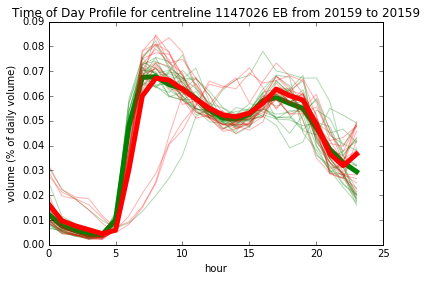

In [211]:
# SCOOT 
nc = []
start_year = 2015
start_month = 9
end_year = 2015    
end_month = 9
end_day = 30
gs = [(1147026,'EB')]
colorss = ['g','y','b','k']

for g in gs:
    plt.figure()
    plt.title('Time of Day Profile for centreline ' + str(g[0]) + ' '+ str(g[1]) + ' from ' + str(start_year) + str(start_month) + ' to '+ str(end_year) + str(end_month))
    for year in range(start_year, end_year+1):
        (sm,em) = get_start_end_month(start_year, end_year, start_month, end_month, year)
        for month in range(sm, em):
            if month < 10:
                m = '0' + str(month)
            else:
                m = str(month)
            # Read in Raw Data
            #sdata = pd.DataFrame(db.query('SELECT detector, start_time, end_time, flow_mean FROM scoot.raw_'+str(year)+m).getresult(),columns=['detector', 'start_time', 'end_time', 'flow_mean'])        
            sdata = pd.read_table('DETS_'+str(year)+m+'.txt', delim_whitespace=True, skiprows=9, header = None, 
                                  names=['Site','DOW','Date','Time_Start','Time_End','flow_mean_veh/h'], usecols=range(6))
            sdata = preprocess_scoot(sdata,sdetectors)

            # Plot TOD
            sncounts, savg, sndays = TOD(sdata,'centreline_id','direction','Date','flow_mean_veh/h',g,colorss,True)
            nc = nc+sncounts
'''        
# Plot availability
nc = pd.DataFrame(nc, columns=['date','ncount'])
nc['date'] = nc['date'].astype(str)
nc['date'] = pd.to_datetime(nc['date']).dt.date

fig = plt.subplots(figsize = [30,10])
plt.plot(nc['date'],nc['ncount'])
plt.grid()
'''

# FLOW
fdata = pd.DataFrame(db.query('SELECT centreline_id, count_bin, volume, dir_bin FROM prj_volume.centreline_volumes \
        WHERE centreline_id in (' + ','.join(corridor_tcl) + ') AND count_bin >= \'' + str(start_year) + '-' + \
        str(start_month) + '-01\' AND count_bin <= \'' + str(end_year) + '-' + str(end_month) + '-' + str(end_day) + '\'').getresult(), 
        columns = ['centreline_id','count_bin','volume','dir_bin'])
fdata = preprocess_flow(fdata)
gf = [(1147026,+1)]
colorsf = ['r','p','o','c']
for g in gf:
    fncounts, favg, fndays = TOD(fdata,'centreline_id','dir_bin','date','volume',g,colorsf,True)

plt.show()

## Daily Volume

Plotting Average Daily Volume from 20159 to 20159...


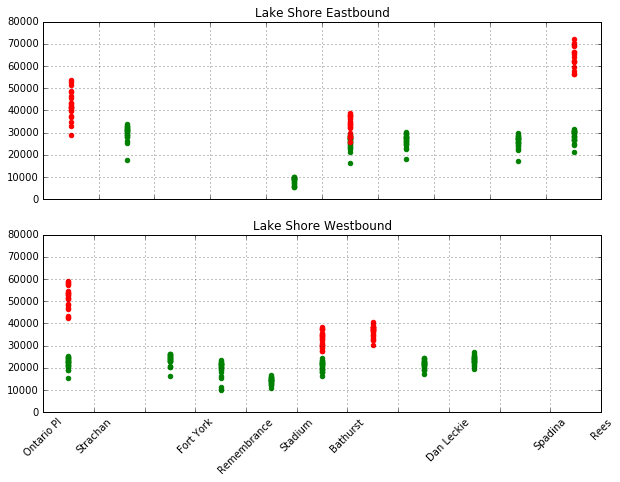

In [176]:
start_year = 2015
start_month = 9
end_year = 2015    
end_month = 9
end_day = 30

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,7), sharex = True, sharey = True)

# SCOOT 
colorss = ['g','y','b','k']
print('Plotting Average Daily Volume from ' + str(start_year) + str(start_month) + ' to '+ str(end_year) + str(end_month) + '...')
for year in range(start_year, end_year+1):
    (sm,em) = get_start_end_month(start_year, end_year, start_month, end_month, year)
    for month in range(sm, em):
        if month < 10:
            m = '0' + str(month)
        else:
            m = str(month)
        # Read in Raw Data
        #sdata = pd.DataFrame(db.query('SELECT detector, start_time, end_time, flow_mean FROM scoot.raw_'+str(year)+m).getresult(),columns=['detector', 'start_time', 'end_time', 'flow_mean'])        
        sdata = pd.read_table('DETS_'+str(year)+m+'.txt', delim_whitespace=True, skiprows=9, header = None, 
                              names=['Site','DOW','Date','Time_Start','Time_End','flow_mean_veh/h'], usecols=range(6))
        sdata = preprocess_scoot(sdata,sdetectors)
        
        daily_vol(sdata,'stopindex','direction','Date','flow_mean_veh/h',colorss)

# FLOW
fdata = pd.DataFrame(db.query('SELECT centreline_id, count_bin, volume, dir_bin FROM prj_volume.centreline_volumes \
        WHERE centreline_id in (' + ','.join(corridor_tcl) + ') AND count_bin >= \'' + str(start_year) + '-' + \
        str(start_month) + '-01\' AND count_bin <= \'' + str(end_year) + '-' + str(end_month) + '-' + str(end_day) + '\'').getresult(), 
        columns = ['centreline_id','count_bin','volume','dir_bin'])
fdata = preprocess_flow(fdata)
colorsf = ['r','p','o','c']
daily_vol(fdata,'stopindex','dir_bin','date','volume',colorsf)

plt.show()

## Seasonality Plot

Plotting SCOOT Data...
Plotting FLOW Data...


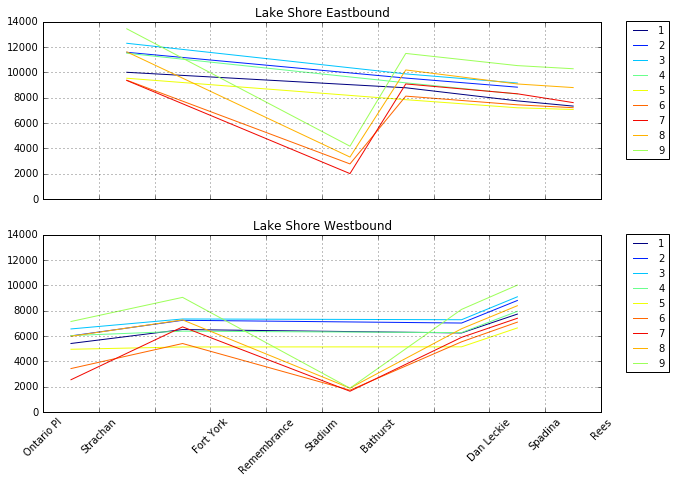

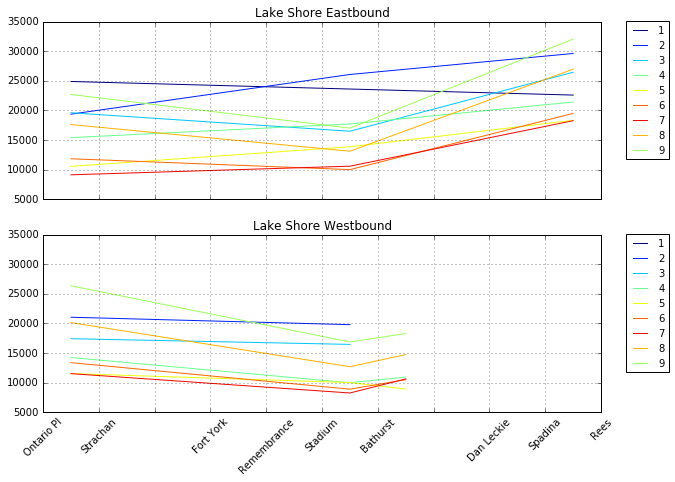

In [208]:
start_year = 2015
start_month = 1
end_year = 2015    
end_month = 9
end_day = 12
cm_subsection = np.append(np.linspace(0,0.8,6) ,np.linspace(0.9,0,6))
colors = [cm.jet(x) for x in cm_subsection]

# SCOOT
print('Plotting SCOOT Data...')
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,7), sharex = True, sharey = True)
for year in range(start_year, end_year+1):
    (sm,em) = get_start_end_month(start_year, end_year, start_month, end_month, year)
    for month in range(sm, em):
        if month < 10:
            m = '0' + str(month)
        else:
            m = str(month)
        # Read in Raw Data
        sdata = pd.read_table('DETS_'+str(year)+m+'.txt', delim_whitespace=True, skiprows=9, header = None, 
                              names=['Site','DOW','Date','Time_Start','Time_End','flow_mean_veh/h','Occ_mean_%'], usecols=range(7))
        sdata = preprocess_scoot(sdata,sdetectors)
        # Plot Seasonality
        seasonality_plot(sdata,'stopindex','direction','Date','flow_mean_veh/h',colors)
plt.show()

# FLOW
print('Plotting FLOW Data...')
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,7), sharex = True, sharey = True)
fdata = pd.DataFrame(db.query('SELECT centreline_id, count_bin, volume, dir_bin FROM prj_volume.centreline_volumes \
        WHERE centreline_id in (' + ','.join(corridor_tcl) + ') AND count_bin >= \'' + str(start_year) + '-' + \
        str(start_month) + '-01\' AND count_bin <= \'' + str(end_year) + '-' + str(end_month) + '-' + str(end_day) + '\'').getresult(), 
        columns = ['centreline_id','count_bin','volume','dir_bin'])
fdata = preprocess_flow(fdata)
seasonality_plot(fdata,'stopindex','dir_bin','date','volume',colors)
plt.show()

## Point by Point Comparison

Plotting 201509...


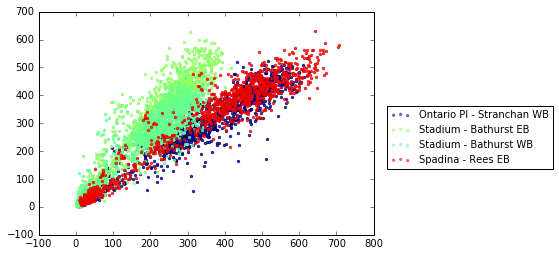

Plotting 201510...


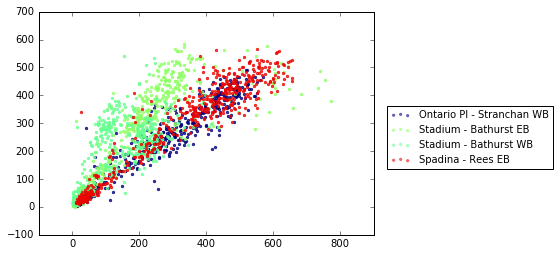

In [207]:
start_year = 2015
start_month = 9
end_year = 2015    
end_month = 10
end_day = 30

cm_subsection = np.linspace(0,1,22)
colors = [cm.jet(x) for x in cm_subsection]
'''
# FLOW
fdata = pd.DataFrame(db.query('SELECT centreline_id, count_bin, volume, dir_bin FROM prj_volume.centreline_volumes \
        WHERE centreline_id in (' + ','.join(corridor_tcl) + ') AND count_bin >= \'' + str(start_year) + '-' + \
        str(start_month) + '-01\' AND count_bin <= \'' + str(end_year) + '-' + str(end_month) + '-' + str(end_day) + '\'').getresult(), 
        columns = ['centreline_id','count_bin','volume','dir_bin'])
fdata = preprocess_flow(fdata)
'''
# SCOOT
for year in range(start_year, end_year+1):
    (sm,em) = get_start_end_month(start_year, end_year, start_month, end_month, year)
    for month in range(sm, em):
        if month < 10:
            m = '0' + str(month)
        else:
            m = str(month)
        plt.figure()
        print ('Plotting ' + str(year) + m + '...' )
        # Read in Raw Data
        sdata = pd.read_table('DETS_'+str(year)+m+'.txt', delim_whitespace=True, skiprows=9, header = None, 
                              names=['Site','DOW','Date','Time_Start','Time_End','flow_mean_veh/h','Occ_mean_%'], usecols=range(7))
        sdata = preprocess_scoot(sdata,sdetectors)
        sdata = sdata.groupby(['Date','centreline_id','stopindex','month','time_15','direction'], as_index=False).sum()
        data = pd.merge(sdata, fdata, how = 'inner', left_on = ['Date','time_15','stopindex','direction'], right_on = ['date','time_15','stopindex','direction'])
        data = data[(data['volume']!=0) & (data['flow_mean_veh/h']!=0)]
        for (index, direc), group in data.groupby(['stopindex','direction']):
            plt.scatter(group['volume'], group['flow_mean_veh/h'], alpha = 0.5, color = colors[int(index)*2+(direc=='EB')], s = 5, label=seg_names[int(index)]+' '+direc)
        plt.legend(prop={'size':10},bbox_to_anchor=(1.55,0.6))
        plt.show()

In [ ]:
db.close()